## British Airways Customer Sentiment Analysis (by Yash Jain)
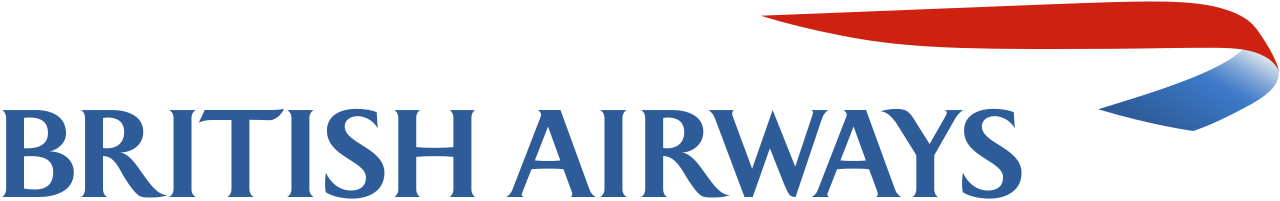

This project is part of the Forage Virtual Experience Program. The task at hand, is to analyze the customer reviews of British Airways, by scraping data from the website https://www.airlinequality.com/airline-reviews/british-airways/. 

The project would take up basic categorical and numerical analysis, before moving towards Sentiment Analysis. For that, further study needs to be done.

### 1. Extraction of Data

We will begin the extraction of data. For that, we will first import all the useful libraries for this project. Let us do it.

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup as bscraper
import warnings as warn
import re as regex

warn.filterwarnings('ignore')

Now, let us use the `requests.get()` method to interact with the webpage, and send a request to fetch its HTML data to our response variable, `html_code`.

In [2]:
url = "https://www.airlinequality.com/airline-reviews/british-airways/"

response = requests.get(url)
html_code = bscraper(response.content,'html.parser')

We have the HTML structure of our data with us. Now, it is time to start extracting data from it. Let us study the major attributes for the data we have at hand. 

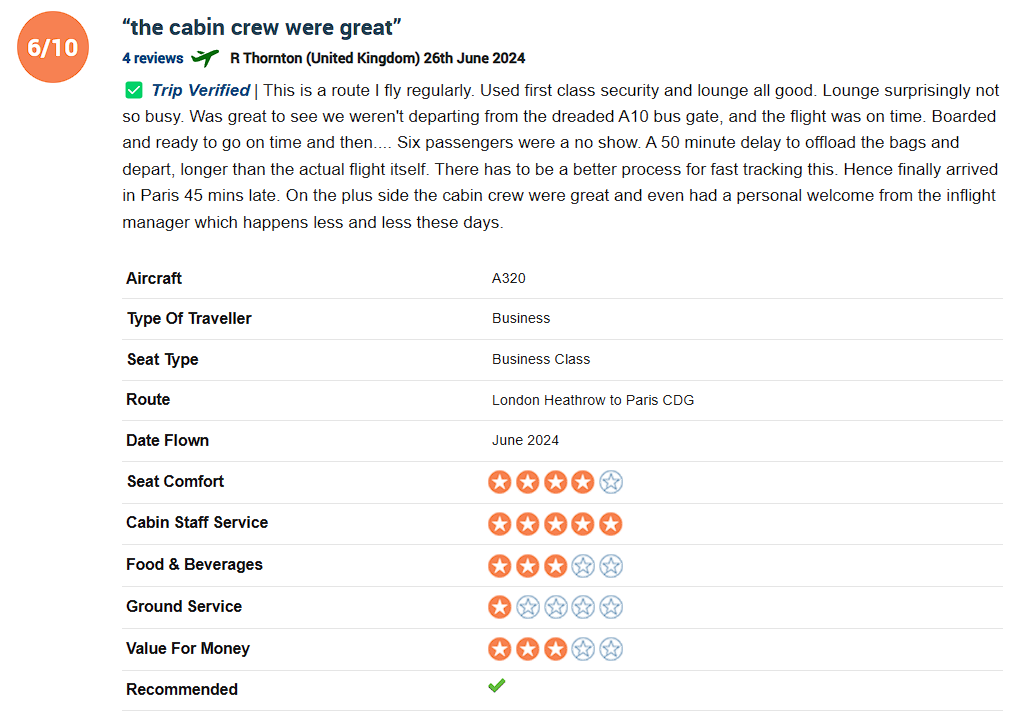

As per the preliminary study, we have the following attributes in our data - 

1. Review Header (text)
2. Overall Rating (ordinal, scale of 10)
3. Review count, Author name, country and date of review - all in a single line
4. Verification status of review
5. Complete textual / descriptive review
6. Aircraft (categorical)
7. Type of Traveller (categorical)
8. Seat Type (cateogorical)
9. Route (categorical)
10. Date Flown (date in mm/yy)
11. Seat Comfort (ordinal, 5-star rating)
12. Cabin Staff Service (ordinal, 5-star rating)
13. Food & Beverages (ordinal, 5-star rating)
14. Inflight Entertainment (ordinal, 5-star rating)
15. Ground Service (ordinal, 5-star rating)
16. Wifi and Connectivity (ordinal, 5-star rating)
17. Value for Money (ordinal, 5-star rating)
18. Recommended (Boolean - Yes/No)

#### Data from Normal Columns

From studying the website, it is evident that extracting data from the embedded tables would be a little tricky. Therefore, we will be shifting our focus towards some columns which's data can be extracted relatively easy. 

Hence, let us extract the column data from other columns - 

1. Review Title
2. Overall Rating
3. Review Meta
4. Complete Review

Let us do it.

In [3]:
review_header = [header.get_text(strip=True) for header in html_code.find_all("h2","text_header")]

rating_value = [float(rating.get_text(strip=True)) 
                for rating in html_code.find_all("span",itemprop="ratingValue")][1:]

#split this into review_count, author_name, author_loc, review_date after extracting data
review_meta = [meta.get_text(strip=True) 
               for meta in html_code.find_all("h3","text_sub_header userStatusWrapper")] 

#split into review_verification and review_content after extracting data
reviews = [text.get_text(strip=True) for text in html_code.find_all("div","text_content")]  

We have successfully extracted data from these columns. Now, it is time to go over the columns, that contain the review data. 

#### Review Data Columns

Now, it is time to extract data from the columns that contain the review data. These columns are embedded within HTML tables, and hence, need to be extracted accordingly.

These columns are - 

1. Aircraft (categorical)
2. Type of Traveller (categorical)
3. Seat Type (cateogorical)
4. Route (categorical)
5. Date Flown (date in mm/yy)
6. Seat Comfort (ordinal, 5-star rating)
7. Cabin Staff Service (ordinal, 5-star rating)
8. Food & Beverages (ordinal, 5-star rating)
9. Inflight Entertainment (ordinal, 5-star rating)
10. Ground Service (ordinal, 5-star rating)
11. Wifi and Connectivity (ordinal, 5-star rating)
12. Value for Money (ordinal, 5-star rating)
13. Recommended (Boolean - Yes/No)

For this, we will create a function, `extract_review_data()` which will have the following parameters - 

1. `html_code` - the beautifulsoup4 object. This will contain the entire HTML structure of the web page.
2. `tag` - this tag would be used to navigate through the function. It will be used to select exactly which tag contains the data we need.
3. `attr` - this parameter would possess the value of the CSS class, of the desired column data. It would be used to pin point the exact HTML structure of the data we are after.
4. `value` - this parameter would describe the CSS class, which contains the value to be extracted. 

Using these parameters, we work the following logic - 

Step 1: We extract the data within the &lt;div&gt; tag having class `review-stats`. Each of the entire review data is within this.

Step 2: Next, we run multiple for-loops, first to extract the specific table data, using the &lt;table&gt; tag having class `review-ratings`, and then, we use the parameters `tag` and `attr` to extract the specific column data's HTML structure. 

Step 3: Once that is done, we check that the header of the column exists or not (in case the review does not contain the column feature), and if it does, we check another thing - if `value` is `stars` - this decides that our column is an ordinal column, and executes the code to extract the data from that column. If the value is not `stars`, then it proceeds to execute the code for extracting the categorical column data. 

Step 4: Initially, we declared an empty list, named `data`, in which the values for the column will be stored. This, alongside the column name will be returned from the function. 

Let us see. 

In [4]:
def extract_review_data(html_code, tag, attr, value):
    review_stats = html_code.find_all("div", "review-stats")
    data = []
    column_name=None

    for code in review_stats:
        for table in code.find_all("table", "review-ratings"):
            header = table.find(tag, attr)

            if header:
                column_name = header.get_text(strip=True)
                if value == "stars":

                    # Extract star ratings
                    stars_td = header.find_next("td", "stars")

                    if stars_td:
                        last_star_fill = stars_td.find_all("span", "star fill")[-1] if stars_td.find_all("span", "star fill") else None
                        data.append(int(last_star_fill.get_text())) if stars_td.find_all("span", "star fill") else data.append(None)

                    else: data.append(None)  # Default value if stars are not found
                        
                else:
                    # Extract normal categorical columns
                    next_td = header.find_next(tag, value)
                    
                    if next_td: data.append(next_td.get_text(strip=True))
                    else: data.append(None)  # Default value if column data is not found
            
            else: data.append(None)  # Default value if header is not found

    return column_name,data


Step 5: This function is applied to each column to extract data from them, and store them in separate variables. Those variables are then used to create a dataframe which stores all the data in the structured format.

In [5]:
#categorical columns
aircraft,val_air = extract_review_data(html_code,"td","aircraft","review-value")
route,val_route = extract_review_data(html_code,"td","route","review-value")
travel,val_travel = extract_review_data(html_code,"td","type_of_traveller","review-value")
seat,val_seat = extract_review_data(html_code,"td","cabin_flown","review-value")
date_flown,val_date = extract_review_data(html_code,"td","date_flown","review-value")
recommended,val_recommend = extract_review_data(html_code,"td","recommended","review-value")

#star columns
seat_comfort,val_seat_comf = extract_review_data(html_code,"td","seat_comfort","stars")
cabin,val_cabin = extract_review_data(html_code,"td","cabin_staff_service","stars")
food,val_food = extract_review_data(html_code,"td","food_and_beverages","stars")
inflight,val_inflight = extract_review_data(html_code,"td","inflight_entertainment","stars")
ground_service,val_ground_service = extract_review_data(html_code,"td","ground_service","stars")
wifi_conn,val_wificonn = extract_review_data(html_code,"td","wifi_and_connectivity","stars")
val_money,val_formoney = extract_review_data(html_code,"td","value_for_money","stars")

In [6]:
df = pd.DataFrame({'Review Title':review_header,
                   'Review Meta': review_meta,
                   'Reviews':reviews,
                   aircraft:val_air, 
                   route: val_route, 
                   travel: val_travel, 
                   seat:val_seat,
                   date_flown: val_date,
                   seat_comfort:val_seat_comf,
                   cabin:val_cabin,
                   food:val_food,
                   inflight:val_inflight,
                   ground_service: val_ground_service,
                   wifi_conn: val_wificonn,
                   val_money: val_formoney,
                   'Overall Rating':rating_value,
                   recommended:val_recommend})

df

,Review Title,Review Meta,Reviews,Aircraft,Route,Type Of Traveller,Seat Type,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money,Overall Rating,Recommended
0,"""disagreeable flight attendant""",10 reviewsJ Meares(United Kingdom)19th March 2025,✅Trip Verified| Flight mainly let down by a ...,Boeing 787,Cape Town to London,Solo Leisure,Business Class,March 2025,5,2,5.0,5.0,4,1.0,4,7.0,yes
1,"""flight was delayed nearly 1 hour""",Luis De Jesus(United States)16th March 2025,✅Trip Verified| Another awful experience by ...,None,London to Geneva,Business,Business Class,December 2024,1,1,NaN,NaN,1,NaN,1,1.0,no
2,"""full of attitude to me""",Luis De Jesus(United States)16th March 2025,"✅Trip Verified| The service was rude, full o...",None,London to New York,Business,Premium Economy,January 2025,1,1,1.0,NaN,5,NaN,1,3.0,no
3,"""service was outrageous""",Luis De Jesus(United States)16th March 2025,✅Trip Verified| This flight was a joke. Ther...,None,Chambery to London,Business,Business Class,January 2025,1,1,2.0,NaN,1,NaN,1,1.0,no
4,"""managed to get everything right""",38 reviewsPaul Mercer(United Kingdom)7th March...,✅Trip Verified| This time British Airways ma...,Boeing 777,Gatwick to Antigua,Business,Premium Economy,March 2025,5,5,4.0,4.0,5,4.0,5,9.0,yes
5,"""The seats were excellent""",A Warden(United Kingdom)28th February 2025,"✅Trip Verified| The seats were excellent, wi...",None,Mumbai to London,Couple Leisure,Premium Economy,February 2025,5,4,3.0,5.0,4,NaN,5,9.0,yes
6,"""the crew were awful""",John Prescott(United Kingdom)27th February 2025,✅Trip Verified| After the nightmare of getti...,A350,Nairobi to London,Couple Leisure,Business Class,February 2025,4,1,2.0,3.0,4,NaN,3,5.0,no
7,"""not use British Airways on this route""",C Barton(United Kingdom)21st February 2025,✅Trip Verified| Prior to boarding a gate age...,A320,London Gatwick to Marrakech,Solo Leisure,Economy Class,February 2025,4,1,NaN,NaN,2,NaN,2,3.0,no
8,"""they still haven't replied""",E Vandoon(Netherlands)18th February 2025,✅Trip Verified| I flew from Amsterdam to Las...,None,Amsterdam to Las Vegas via London,Business,Premium Economy,November 2024,3,3,3.0,3.0,1,NaN,1,1.0,no
9,“food has really gone downhill”,John Prescott(United Kingdom)14th February 2025,"✅Trip Verified| First the good news, the club ...",A350-1000,London to Nairobi,Couple Leisure,Business Class,February 2025,4,1,2.0,NaN,3,NaN,3,4.0,no


We can see that our dataset is ready. Let us check its basic information. 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Review Title            10 non-null     object 
 1   Review Meta             10 non-null     object 
 2   Reviews                 10 non-null     object 
 3   Aircraft                5 non-null      object 
 4   Route                   10 non-null     object 
 5   Type Of Traveller       10 non-null     object 
 6   Seat Type               10 non-null     object 
 7   Date Flown              10 non-null     object 
 8   Seat Comfort            10 non-null     int64  
 9   Cabin Staff Service     10 non-null     int64  
 10  Food & Beverages        8 non-null      float64
 11  Inflight Entertainment  5 non-null      float64
 12  Ground Service          10 non-null     int64  
 13  Wifi & Connectivity     2 non-null      float64
 14  Value For Money         10 non-null     int64

We have all 17 columns. Now, here's a surprise - this is one page, out of 383 pages. Hence, let us write the code to execute everything for all the pages, to prepare our entire dataset. 

#### Extracting Data for all pages

Now we know, our code is working. Let us apply this code, to be used for every page in the website, on which the data lies. Let us proceed.

We will create 2 functions for this purpose - 

1. `extract_review_data()` - This function is exactly the same as before. It will extract review data embedded inside the tables on the webpages. It will return two values - column name, and list of values. 
2. `fetch_review_data()` - This is a new function. It contains the entire setup of all columns, and the resultant dataframe, which would be returned. It would take the url of the webpage as input. 

We would simply run these functions through each page, and then combine all the data extracted, into one, large dataframe, to be ready for transformation.

Let us proceed.

In [8]:
# Function to fetch data from a single page
def fetch_review_data(url):
    
    response = requests.get(url)
    html_code = bscraper(response.content, 'html.parser')

    # Extracting review headers
    review_header = [header.get_text(strip=True) for header in html_code.find_all("h2", "text_header")]

    # Extracting ratings
    rating_value = [int(rate.get_text(strip=True).split('/')[0]) 
                if rate.find_all("span",itemprop="ratingValue") else None
                for rate in html_code.find_all("div","rating-10")][1:]

    # Extracting review metadata
    review_meta = [meta.get_text(strip=True) for meta in html_code.find_all("h3", "text_sub_header userStatusWrapper")]

    # Extracting review content
    reviews = [text.get_text(strip=True) for text in html_code.find_all("div", "text_content")]

    # Extracting categorical columns
    aircraft, val_air = extract_review_data(html_code, "td", "aircraft", "review-value")
    route, val_route = extract_review_data(html_code, "td", "route", "review-value")
    travel, val_travel = extract_review_data(html_code, "td", "type_of_traveller", "review-value")
    seat, val_seat = extract_review_data(html_code, "td", "cabin_flown", "review-value")
    date_flown, val_date = extract_review_data(html_code, "td", "date_flown", "review-value")
    recommended, val_recommend = extract_review_data(html_code, "td", "recommended", "review-value")

    # Extracting star rating columns
    seat_comfort, val_seat_comf = extract_review_data(html_code, "td", "seat_comfort", "stars")
    cabin, val_cabin = extract_review_data(html_code, "td", "cabin_staff_service", "stars")
    food, val_food = extract_review_data(html_code, "td", "food_and_beverages", "stars")
    inflight, val_inflight = extract_review_data(html_code, "td", "inflight_entertainment", "stars")
    ground_service, val_ground_service = extract_review_data(html_code, "td", "ground_service", "stars")
    wifi_conn, val_wificonn = extract_review_data(html_code, "td", "wifi_and_connectivity", "stars")
    val_money, val_formoney = extract_review_data(html_code, "td", "value_for_money", "stars")

    # Creating DataFrame
    df = pd.DataFrame({'Review Title':review_header,
                       'Review Meta': review_meta,
                       'Reviews':reviews,
                       aircraft:val_air, 
                       route: val_route, 
                       travel: val_travel, 
                       seat:val_seat,
                       date_flown: val_date,
                       seat_comfort:val_seat_comf,
                       cabin:val_cabin,
                       food:val_food,
                       inflight:val_inflight,
                       ground_service: val_ground_service,
                       wifi_conn: val_wificonn,
                       val_money: val_formoney,
                       'Overall Rating':rating_value,
                       recommended:val_recommend})

    return df

#extracting total pages
nav = html_code.find_all('article','comp comp_reviews-pagination querylist-pagination position-')
total_pages = [int(page.find_all("a",
                attrs={'href':True, 'class':False})[-2].get_text()) 
                for page in nav][0]

In [10]:
# Initialize an empty list to store all pages' data
all_data = []

# Loop through all 383 pages (adjust range according to your specific page numbers)
for page_number in range(1, total_pages+1):
    url = f"https://www.airlinequality.com/airline-reviews/british-airways/page/{page_number}"  # Replace with your actual URL pattern
    page_data = fetch_review_data(url)
    all_data.append(page_data)

# Concatenate all data into a single DataFrame
airlines_review_data = pd.concat(all_data, ignore_index=True).iloc[:,:-1]
airlines_review_data


KeyboardInterrupt: 

We can see an additional column `None` here, which is created due to the function `extract_review_data()`. We will drop this column, and see the dataframe info now.

In [182]:
airlines_review_data = airlines_review_data.iloc[:,:-1]
airlines_review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3822 entries, 0 to 3821
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Review Title            3822 non-null   object 
 1   Review Meta             3822 non-null   object 
 2   Reviews                 3822 non-null   object 
 3   Aircraft                1993 non-null   object 
 4   Route                   3047 non-null   object 
 5   Type Of Traveller       3051 non-null   object 
 6   Seat Type               3819 non-null   object 
 7   Date Flown              3044 non-null   object 
 8   Seat Comfort            3699 non-null   float64
 9   Cabin Staff Service     3686 non-null   float64
 10  Food & Beverages        3407 non-null   float64
 11  Inflight Entertainment  2617 non-null   float64
 12  Ground Service          2973 non-null   float64
 13  Wifi & Connectivity     654 non-null    float64
 14  Value For Money         3821 non-null   

Hence, our data is now extracted. It is time to move towards the next step - Transformation.

### 2. Data Transformation

Now, it comes to transforming our data. We will be undergoing inspection, missing value handling, correction of incorrect values, creation of new columns as per need, in order to prepare our dataframe entirely for analysis. 

Once it is ready, we will be loading this into MySQL Database. Further, we will try to incorporate incremental loading, which would load only the new data, onto the database.

Let us proceed with inspecting our dataframe.

In [ ]:
import aiohttp
import asyncio
import pandas as pd
from bs4 import BeautifulSoup as bs
import nest_asyncio  # Fix for Jupyter Notebook

nest_asyncio.apply()  # Allow asyncio to work inside Jupyter

BASE_URL = "https://www.airlinequality.com/airline-reviews/british-airways/page/{}/"

async def fetch_page(session, url):
    """Fetches a webpage asynchronously."""
    async with session.get(url) as response:
        return await response.text()
    
async def extract_column_names_from_page(session, url):
    """Extracts column names from a single page."""
    html = await fetch_page(session, url)
    soup = bs(html, "html.parser")

    columns = set()  # Store unique column names for this page
    review_sections = soup.find_all("div", class_="body")  # Find all reviews

    for review in review_sections:
        for row in review.find_all("tr"):  # Extract column names dynamically
            key_tag = row.find("td")  # First <td> contains column name
            if key_tag:
                column_name = key_tag.get_text(strip=True)
                columns.add(column_name)  # Add to the set

    return columns

async def extract_all_column_names(total_pages=393):
    """Extracts column names from all pages."""
    async with aiohttp.ClientSession() as session:
        tasks = [extract_column_names_from_page(session, BASE_URL.format(i)) for i in range(1, total_pages + 1)]
        all_columns_per_page = await asyncio.gather(*tasks)  # Run all page extractions concurrently

    # Finding common and unique columns across all pages
    all_columns = set().union(*all_columns_per_page)  # All unique columns
    common_columns = set.intersection(*all_columns_per_page)  # Only columns that appear on every page

    return all_columns

async def extract_reviews_from_page(session, url, all_columns):
    """Extracts review data dynamically from a single page, fixing star ratings & overall rating."""
    html = await fetch_page(session, url)
    soup = bs(html, "html.parser")

    reviews_data = []  # Store structured review data

    # Find all reviews on the page
    review_sections = soup.find_all("article", itemprop="review")

    for review in review_sections:
        review_data = {col: None for col in all_columns}  # Initialize all values as None

        # Extract reviewer ID
        reviewer_div = review.find("div", id=True)  # Find the div that has an ID

        if reviewer_div:  # Ensure div exists
            review_id = reviewer_div.get("id")  # Extract the ID
            if review_id and review_id.startswith("anchor"):  # Check if it starts with 'anchor'
                review_id = review_id.replace("anchor", "")  # Remove 'anchor' prefix
            else:
                review_id = None  # If ID exists but is not formatted correctly
        else:
            review_id = None  # If no div with ID is found

        review_data["Reviewer ID"] = review_id  # Store in dictionary

        
        # Extract review title
        title_tag = review.find("h2", class_="text_header")
        review_data["Review Title"] = title_tag.get_text(strip=True) if title_tag else None

        # Extract review metadata (author, date, etc.)
        meta_tag = review.find("h3", class_="text_sub_header userStatusWrapper")
        review_data["Review Meta"] = meta_tag.get_text(strip=True) if meta_tag else None

        # Extract review content
        content_tag = review.find("div", class_="text_content")
        review_data["Review Content"] = content_tag.get_text(strip=True) if content_tag else None

        # Extract overall rating
        rating_container = review.find("div", itemprop="reviewRating")  # Locate overall rating container
        review_data["Overall Rating"] = rating_container.get_text(strip=True).split("/")[0] if rating_container else None
 
        # ✅ Fix: Extract Star Ratings correctly
        for row in review.find_all("tr"):
            key_tag = row.find("td")  # First <td> contains column name
            value_tag = row.find("td", class_="review-value") or row.find("td", class_="stars")

            if key_tag:
                key = key_tag.get_text(strip=True)  # Parameter name

                if value_tag:
                    if "stars" in value_tag.get("class", []):  # If it's a star rating column
                        stars_filled = len(value_tag.find_all("span", class_="star fill"))  # Count filled stars ⭐
                        review_data[key] = stars_filled  # Assign numerical value (e.g., 4 stars → 4)
                    else:
                        review_data[key] = value_tag.get_text(strip=True)  # Assign text value

        reviews_data.append(review_data)  # Store review data

    return reviews_data

async def scrape_all_reviews(total_pages=393):
    """Extracts all reviews dynamically and creates a structured DataFrame."""
    
    # Step 1: Extract all unique column names dynamically
    all_columns = await extract_all_column_names(total_pages)

    # Add fixed columns that will always be present
    all_columns.update(["Reviewer ID", "Review Title", "Review Meta", "Review Content", "Overall Rating"])

    async with aiohttp.ClientSession() as session:
        tasks = [extract_reviews_from_page(session, BASE_URL.format(i), all_columns) for i in range(1, total_pages + 1)]
        all_reviews = await asyncio.gather(*tasks)  # Run all page extractions concurrently

    # Flatten the list (since gather returns a list of lists)
    all_reviews_flat = [review for page_reviews in all_reviews for review in page_reviews]

    # Convert to Pandas DataFrame
    df = pd.DataFrame(all_reviews_flat)

    return df

# Example usage: Scrape all reviews dynamically
df_reviews = asyncio.get_event_loop().run_until_complete(scrape_all_reviews(393))

# Display the DataFrame
df_reviews

,Cabin Staff Service,Seat Type,Recommended,Inflight Entertainment,Reviewer ID,Review Content,Value For Money,Route,Seat Comfort,Wifi & Connectivity,Date Flown,Food & Beverages,Aircraft,Overall Rating,Review Title,Ground Service,Review Meta,Type Of Traveller
0,2.0,Business Class,yes,5.0,921004,✅Trip Verified| Flight mainly let down by a ...,4,Cape Town to London,5.0,1.0,March 2025,5.0,Boeing 787,7,"""disagreeable flight attendant""",4.0,10 reviewsJ Meares(United Kingdom)19th March 2025,Solo Leisure
1,1.0,Business Class,no,NaN,920795,✅Trip Verified| Another awful experience by ...,1,London to Geneva,1.0,NaN,December 2024,NaN,None,1,"""flight was delayed nearly 1 hour""",1.0,Luis De Jesus(United States)16th March 2025,Business
2,1.0,Premium Economy,no,NaN,920791,"✅Trip Verified| The service was rude, full o...",1,London to New York,1.0,NaN,January 2025,1.0,None,3,"""full of attitude to me""",5.0,Luis De Jesus(United States)16th March 2025,Business
3,1.0,Business Class,no,NaN,920793,✅Trip Verified| This flight was a joke. Ther...,1,Chambery to London,1.0,NaN,January 2025,2.0,None,1,"""service was outrageous""",1.0,Luis De Jesus(United States)16th March 2025,Business
4,5.0,Premium Economy,yes,4.0,920342,✅Trip Verified| This time British Airways ma...,5,Gatwick to Antigua,5.0,4.0,March 2025,4.0,Boeing 777,9,"""managed to get everything right""",5.0,38 reviewsPaul Mercer(United Kingdom)7th March...,Business
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919,3.0,Business Class,no,3.0,243813,Business LHR to BKK. 747-400. First try back w...,2,None,4.0,NaN,None,2.0,None,4,British Airways customer review,NaN,Bruce Bettridge(United Kingdom)29th August 2012,None
3920,5.0,Business Class,yes,0.0,243823,LHR to HAM. Purser addresses all club passenge...,3,None,4.0,NaN,None,4.0,None,9,British Airways customer review,NaN,Nick Berry(United Kingdom)28th August 2012,None
3921,NaN,Economy Class,yes,NaN,243776,My son who had worked for British Airways urge...,4,None,NaN,NaN,None,NaN,None,5,British Airways customer review,NaN,Avril Barclay(United Kingdom)12th October 2011,None
3922,3.0,Premium Economy,no,0.0,243824,London City-New York JFK via Shannon on A318 b...,1,None,1.0,NaN,None,5.0,None,4,British Airways customer review,NaN,C Volz(United States)11th October 2011,None


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3924 entries, 0 to 3923
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Cabin Staff Service     3782 non-null   float64
 1   Seat Type               3922 non-null   object 
 2   Recommended             3924 non-null   object 
 3   Inflight Entertainment  2680 non-null   float64
 4   Reviewer ID             3924 non-null   object 
 5   Review Content          3924 non-null   object 
 6   Value For Money         3924 non-null   int64  
 7   Route                   3148 non-null   object 
 8   Seat Comfort            3797 non-null   float64
 9   Wifi & Connectivity     688 non-null    float64
 10  Date Flown              3146 non-null   object 
 11  Food & Beverages        3485 non-null   float64
 12  Aircraft                2044 non-null   object 
 13  Overall Rating          3919 non-null   object 
 14  Review Title            3924 non-null   